# <font color='blue'>Deep Learning II</font>

# Recurrent Neural Networks

Redes Neurais Recorrentes ou RNNs são um tipo especial de rede neural projetada para problemas sequenciais. Considerando uma rede padrão Multilayer Perceptron, uma rede neural recorrente pode ser pensada como a adição de loops à arquitetura. Por exemplo, em uma dada camada, cada neurônio pode passar seu sinal para frente (feed-forward) e também para o lado. 

Uma Rede Neural Recorrente é basicamente uma rede neural que pode ser usada quando seus dados são tratados como uma sequência, onde a ordem particular dos pontos de dados é importante e esta sequência pode ser de comprimento arbitrário.

O exemplo mais claro é talvez uma série temporal de números, onde a tarefa é prever o próximo valor de acordo com valores anteriores. A entrada para a RNN em cada passo de tempo é o valor atual, bem como um vetor de estado que representa o que a rede "viu" no tempo - etapas anteriores. Este estado-vetor é a memória codificada da RNN, inicialmente definida como zero.

## Prevendo Séries Temporais com Multilayer Perceptron


Previsão de Capacidade do Mainframe - Consumo dos Jobs do Broker

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o Consumo dos Jobs do Broker. 

In [1]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [2]:
import keras as k
k.__version__

'2.5.0'

In [22]:
# Imports
import math
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

from pandas.tseries.offsets import DateOffset
from time import time
from datetime import datetime

# Imports para visualização de dados
import matplotlib as m

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [4]:
# Random seed 
numpy.random.seed(7)

In [5]:
# Carrega os dataframe
dataframe = pd.read_csv("./CSV/pipaColBrokerDia.csv")
dataframe['DATA'] = pd.to_datetime(dataframe.DATA, format = '%Y-%m-%dT%H:%M:%S.%fZ')
dataframe.rename(columns={'DATA': 'Data'}, inplace=True)
dataframe = dataframe[['Data','BROKER','SERVICE_NAME','SERVICE_CLASS','PROGRAMA', 'QUANTIDADE']]
dataframe.rename(columns={'BROKER': 'Broker', 'SERVICE_NAME': 'Service_name', 'SERVICE_CLASS': 'Service_class',
                      'PROGRAMA': 'Programa', 'QUANTIDADE': 'Quantidade'}, inplace=True)
dataframe

,Data,Broker,Service_name,Service_class,Programa,Quantidade
0,2021-11-27,ETB160,DETRAN,SDGX,NSDGX047,6
1,2021-11-27,ETB160,DETRAN,SDGX,NSDAKG12,1
2,2021-11-27,ETB160,DETRAN,SDGX,NSDAKQ08,1
3,2021-11-27,ETB160,DETRAN,SDGX,NSDAKQ07,1
4,2021-11-27,ETB160,DETRAN,SDGX,NSDGX414,1
...,...,...,...,...,...,...
71289,2022-10-24,ETB170,PORTALDETRAN,SDGX,NSDGX500,217
71290,2022-10-24,ETB170,PORTALDETRAN,SDGX,NSDGX495,9
71291,2022-10-24,ETB170,PORTALDETRAN,SDGX,NSDGX469,121
71292,2022-10-24,ETB170,PORTALDETRAN,SDGX,NSDGX467,12


In [6]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71294 entries, 0 to 71293
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Data           71294 non-null  datetime64[ns]
 1   Broker         71294 non-null  object        
 2   Service_name   71294 non-null  object        
 3   Service_class  71294 non-null  object        
 4   Programa       71294 non-null  object        
 5   Quantidade     71294 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 3.3+ MB


In [7]:
# Carregando os dados
# Podemos carregar este conjunto de dados facilmente usando a biblioteca Pandas. Não estamos interessados na data,
# pois que cada observação é separada pelo mesmo intervalo de um mês. Portanto, quando
# carregamos o conjunto de dados, podemos excluir a primeira coluna. O conjunto de dados baixado também tem rodapé
# com informações que podemos excluir com o argumento skipfooter para pandas.read_csv() 
# Uma vez carregado, podemos plotar facilmente todo o conjunto de dados. 

dataset = dataframe.copy()

filtro1 = dataset['Broker']=='ETB170'
filtro2 = dataset['Service_name']=='PORTALDETRAN'
filtro3 = dataset['Programa']=='NSDGX500'
dataset = dataset[filtro1 & filtro2 & filtro3]

dataset = dataset.rename_axis('index').reset_index()
dataset.drop(columns=['index','Broker','Service_name','Service_class','Programa'], inplace=True)
dataset

In [8]:
dataset

,Data,Quantidade
0,2021-11-27,96
1,2021-11-26,82
2,2021-11-25,50
3,2021-11-24,50
4,2021-11-23,100
...,...,...
572,2022-10-21,78
573,2022-10-22,65
574,2022-10-24,79
575,2022-10-25,176


In [9]:
# Remove as linhas com as datas duplicadas
# Vamos transformar a coluna de data no índice do conjunto de dados. Isso vai facilitar nosso trabalho mais a frente.
# inclui dados missing com a interpolação 

dataset.drop_duplicates(subset='Data', inplace=True)
dataset = dataset.set_index('Data')
dataset = dataset.resample('D').interpolate()
dataset

,Quantidade
Data,
2021-10-26,162.0
2021-10-27,66.0
2021-10-28,58.0
2021-10-29,44.0
2021-10-30,83.0
...,...
2022-10-21,207.0
2022-10-22,22.0
2022-10-23,50.5


In [10]:
dataset = dataset.values
dataset = dataset.astype('float32')

In [11]:
# Dados
dataset

array([[162.      ],
       [ 66.      ],
       [ 58.      ],
       [ 44.      ],
       [ 83.      ],
       [ 84.5     ],
       [ 86.      ],
       [ 87.      ],
       [ 88.      ],
       [ 63.      ],
       [212.      ],
       [ 64.      ],
       [ 90.5     ],
       [117.      ],
       [ 50.      ],
       [115.      ],
       [ 54.      ],
       [ 92.      ],
       [124.      ],
       [103.333336],
       [ 82.666664],
       [ 62.      ],
       [106.      ],
       [ 33.      ],
       [120.      ],
       [107.      ],
       [145.5     ],
       [184.      ],
       [100.      ],
       [ 50.      ],
       [ 50.      ],
       [ 82.      ],
       [ 96.      ],
       [ 83.      ],
       [ 70.      ],
       [ 98.      ],
       [  4.      ],
       [111.      ],
       [194.      ],
       [  3.      ],
       [ 48.5     ],
       [ 94.      ],
       [ 95.      ],
       [135.      ],
       [ 14.      ],
       [  4.      ],
       [215.      ],
       [109. 

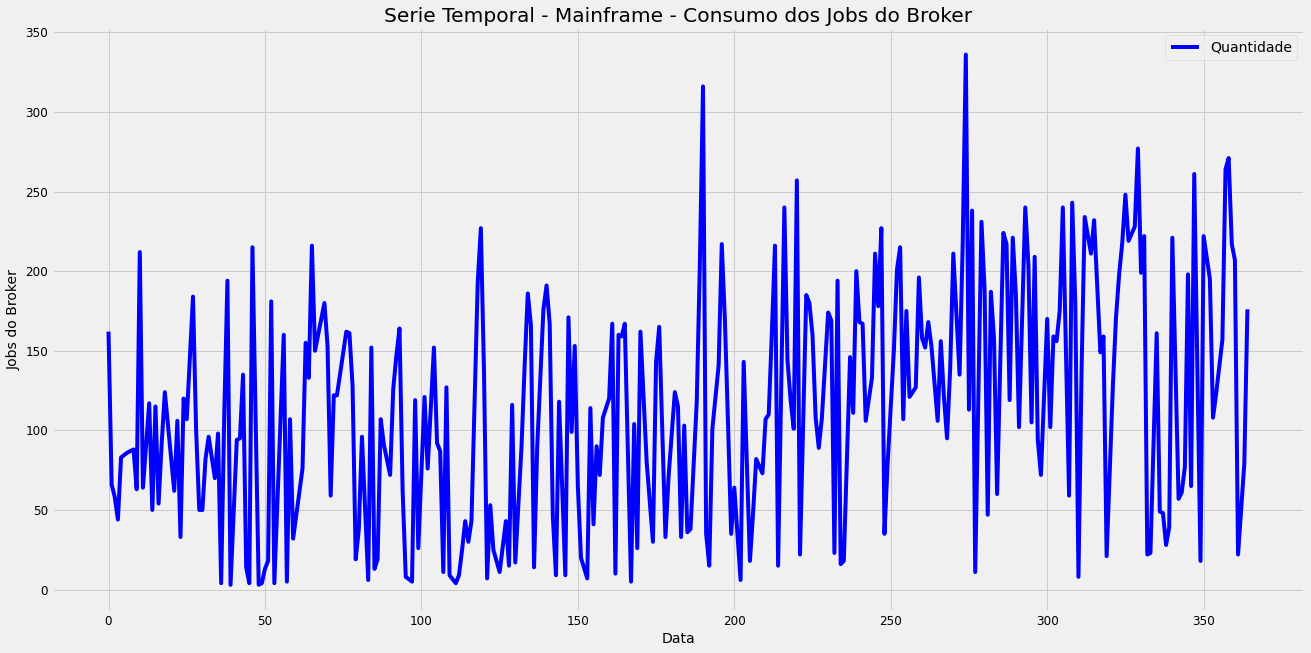

In [12]:
# Plot
plt.title("Serie Temporal - Mainframe - Consumo dos Jobs do Broker")
plt.plot(dataset, label = "Quantidade", color = 'blue')
plt.xlabel("Data")
plt.ylabel("Jobs do Broker")
plt.legend(loc = "best")

In [13]:
# Split em treino e teste
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

273 92


In [14]:
# Agora podemos definir uma função para criar um novo conjunto de dados como descrito acima. A função
# recebe 2 argumentos: o conjunto de dados, que é um array NumPy que queremos converter em um dataset e
# look back que é o número de etapas de tempo anteriores para usar como variáveis de entrada para prever
# O próximo período de tempo, neste caso, definido como 1. Esse padrão criará um conjunto de dados onde X é
# o número de passageiros em um determinado momento (t) e Y é o número de passageiros no próximo
# momento (t + 1). 
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [15]:
# Reshape em X = t e Y = t + 1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Imprimindo dataset de treino
#print(trainX[0:2], trainY[0:2])

# Imprimindo dataset original
#print("\n", dataset[0:3])

In [25]:
# Cria o modelo MLP - RNA - com 1 input, 1 camada oculta com 8 neurônios e uma camada de saída

# Treinamento
start = time()
current_time = datetime.now().strftime("%H:%M:%S")
print("Hora de Início =", current_time)

model = Sequential()

# Camada oculta
model.add(Dense(8, input_dim = look_back, activation = 'relu'))

# Camada de saída
model.add(Dense(1))

# Compilação
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

# Fit do modelo
model.fit(trainX, trainY, epochs = 200, batch_size = 2, verbose = 2)

current_time = datetime.now().strftime("%H:%M:%S")
print("\nHora de Término =", current_time)    
print ('Tempo gasto: %s segundos' % str(time() - start))

Hora de Início = 21:01:40
Epoch 1/200
136/136 - 22s - loss: 35436.6641
Epoch 2/200
136/136 - 0s - loss: 22000.4316
Epoch 3/200
136/136 - 0s - loss: 13799.4639
Epoch 4/200
136/136 - 0s - loss: 9074.1006
Epoch 5/200
136/136 - 0s - loss: 6583.1650
Epoch 6/200
136/136 - 0s - loss: 5439.1206
Epoch 7/200
136/136 - 0s - loss: 4969.7158
Epoch 8/200
136/136 - 0s - loss: 4803.3594
Epoch 9/200
136/136 - 0s - loss: 4739.9375
Epoch 10/200
136/136 - 0s - loss: 4716.6338
Epoch 11/200
136/136 - 0s - loss: 4715.1689
Epoch 12/200
136/136 - 0s - loss: 4700.9155
Epoch 13/200
136/136 - 0s - loss: 4698.8887
Epoch 14/200
136/136 - 0s - loss: 4705.8940
Epoch 15/200
136/136 - 0s - loss: 4692.3999
Epoch 16/200
136/136 - 0s - loss: 4692.2275
Epoch 17/200
136/136 - 0s - loss: 4680.5317
Epoch 18/200
136/136 - 0s - loss: 4681.3662
Epoch 19/200
136/136 - 0s - loss: 4687.5610
Epoch 20/200
136/136 - 0s - loss: 4672.9917
Epoch 21/200
136/136 - 0s - loss: 4671.1733
Epoch 22/200
136/136 - 0s - loss: 4660.9170
Epoch 23/20

Epoch 185/200
136/136 - 0s - loss: 3952.4382
Epoch 186/200
136/136 - 0s - loss: 3953.8127
Epoch 187/200
136/136 - 0s - loss: 3936.8813
Epoch 188/200
136/136 - 0s - loss: 3940.3901
Epoch 189/200
136/136 - 0s - loss: 3946.7100
Epoch 190/200
136/136 - 0s - loss: 3928.6389
Epoch 191/200
136/136 - 0s - loss: 3921.1052
Epoch 192/200
136/136 - 0s - loss: 3918.7307
Epoch 193/200
136/136 - 0s - loss: 3925.0227
Epoch 194/200
136/136 - 0s - loss: 3919.9729
Epoch 195/200
136/136 - 0s - loss: 3910.2937
Epoch 196/200
136/136 - 0s - loss: 3912.6770
Epoch 197/200
136/136 - 0s - loss: 3943.3823
Epoch 198/200
136/136 - 0s - loss: 3905.0654
Epoch 199/200
136/136 - 0s - loss: 3914.9146
Epoch 200/200
136/136 - 0s - loss: 3904.2817

Tempo gasto: 111.4956693649292 segundos


In [26]:
# Estima a performance do modelo
# Tomando a raiz quadrada das estimativas de desempenho, podemos ver que o modelo tem um
# erro médio no conjunto de dados de treinamento e no conjunto de dados de teste.

trainScore = model.evaluate(trainX, trainY, verbose = 0)
print('Score em Treino: %.4f MSE (%.4f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose = 0)
print('Score em Teste: %.4f MSE (%.4f RMSE)' % (testScore, math.sqrt(testScore)))

Score em Treino: 3877.4834 MSE (62.2694 RMSE)
Score em Teste: 7046.1528 MSE (83.9414 RMSE)


In [27]:
# Gera previsões
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [28]:
# Ajusta os dados de treino para o Plot
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [29]:
# Ajusta os dados de teste para o Plot
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

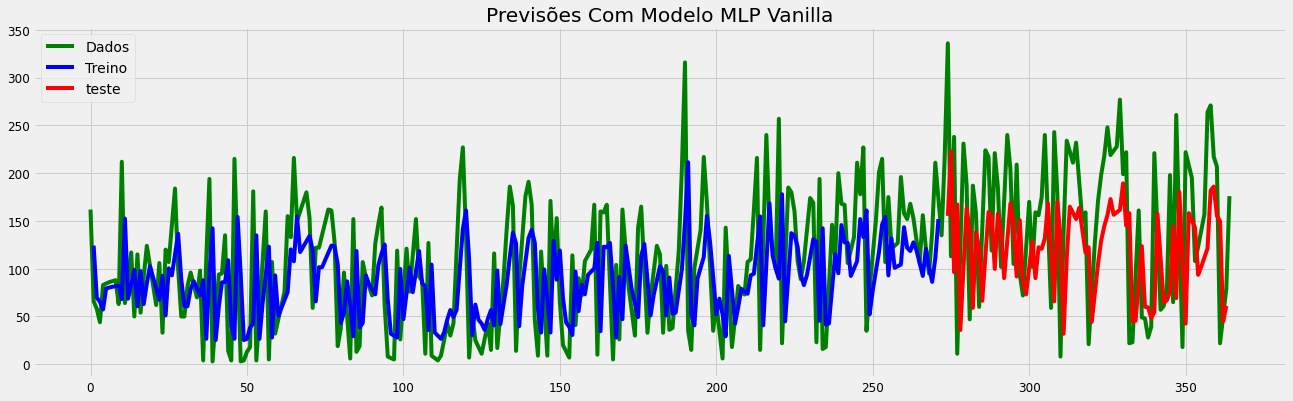

In [30]:
# Plot
plt.figure(figsize = (20, 6))
plt.title('Previsões Com Modelo MLP Vanilla')
plt.plot(dataset, label = 'Dados', color = 'green')
plt.plot(trainPredictPlot, label = 'Treino', color = 'blue')
plt.plot(testPredictPlot, label = 'teste', color = 'Red')
plt.legend(loc = 'upper left')
plt.show()

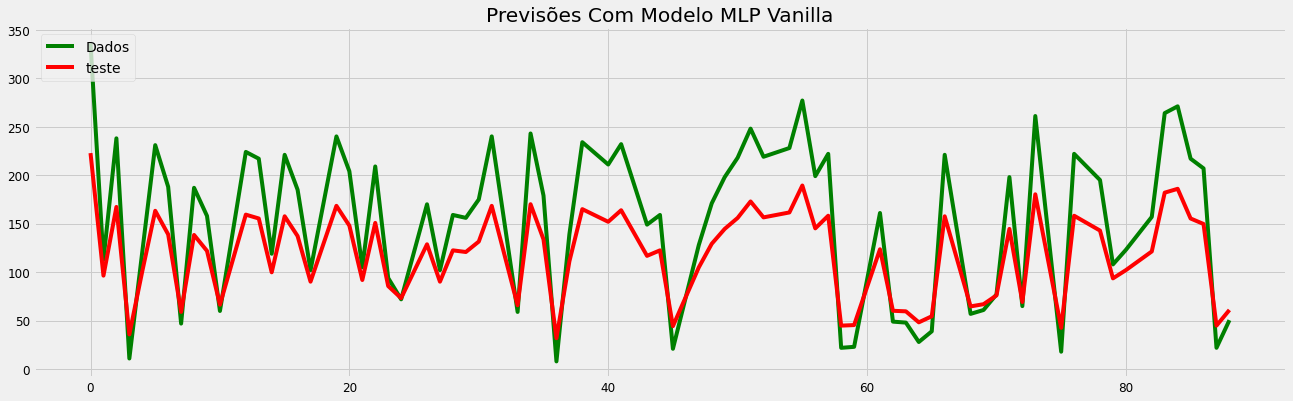

In [31]:
# Plot
plt.figure(figsize = (20, 6))
plt.title('Previsões Com Modelo MLP Vanilla')
plt.plot(dataset[-len(testPredict)-1:-2], label = 'Dados', color = 'green')
plt.plot(testPredictPlot[-len(testPredict-1):], label = 'teste', color = 'Red')
plt.legend(loc = 'upper left')
plt.show()

## Prevendo Séries Temporais com Multilayer Perceptron e Usando Método Window

Podemos também tentar resolver o problema de modo que várias etapas de tempo recente possam ser usadas para a previsão do próximo passo. Isso é chamado de método de janela (Window) e o tamanho da janela é um parâmetro que pode ser sintonizado para cada problema. Por exemplo, dado o tempo atual (t) nós queremos prever o valor na próxima vez na sequência (t + 1), podemos usar o tempo atual (T) bem como os dois tempos anteriores (t-1 e t-2). Quando formulado como um problema de regressão, as variáveis de entrada são t-2, t-1, t e a variável de saída é t + 1.

In [59]:
# Carregando os dados
dataset = dataframe.copy()
filtro1 = dataset['Broker']=='ETB170'
filtro2 = dataset['Service_name']=='PORTALDETRAN'
filtro3 = dataset['Programa']=='NSDGX500'
dataset = dataset[filtro1 & filtro2 & filtro3]

dataset.drop(columns=['Broker','Service_name','Service_class','Programa'], inplace=True)

In [60]:
# Remove as linhas com as datas duplicadas
# Vamos transformar a coluna de data no índice do conjunto de dados. Isso vai facilitar nosso trabalho mais a frente.
# inclui dados missing com a interpolação 

dataset.drop_duplicates(subset='Data', inplace=True)
dataset = dataset.set_index('Data')
dataset = dataset.resample('D').interpolate()

In [61]:
target = dataset['Quantidade']

In [62]:
raw_values = target.values

In [63]:
# Carregando os dados
# Podemos carregar este conjunto de dados facilmente usando a biblioteca Pandas. Não estamos interessados na data,
# pois que cada observação é separada pelo mesmo intervalo de um mês. Portanto, quando
# carregamos o conjunto de dados, podemos excluir a primeira coluna. O conjunto de dados baixado também tem rodapé
# com informações que podemos excluir com o argumento skipfooter para pandas.read_csv() 
# Uma vez carregado, podemos plotar facilmente todo o conjunto de dados. 

dataset = dataset.values
dataset = dataset.astype('float32')

In [64]:
# Split em treino e teste
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

273 92


In [38]:
# Reshape em X = t e Y = t + 10
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [39]:
# Modelo MLP - Treinamento
start = time()
current_time = datetime.now().strftime("%H:%M:%S")
print("Hora de Início =", current_time)

model = Sequential()
model.add(Dense(8, input_dim = look_back, activation = 'relu'))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

current_time = datetime.now().strftime("%H:%M:%S")
print("\nHora de Término =", current_time)  
print ('Tempo gasto: %s segundos' % str(time() - start))

Hora de Início = 21:08:07
Epoch 1/200
131/131 - 1s - loss: 13536.6865
Epoch 2/200
131/131 - 0s - loss: 6601.6802
Epoch 3/200
131/131 - 0s - loss: 5681.3320
Epoch 4/200
131/131 - 0s - loss: 5132.1226
Epoch 5/200
131/131 - 0s - loss: 4750.0371
Epoch 6/200
131/131 - 0s - loss: 4437.4053
Epoch 7/200
131/131 - 0s - loss: 4277.9365
Epoch 8/200
131/131 - 0s - loss: 4090.3770
Epoch 9/200
131/131 - 0s - loss: 3985.3318
Epoch 10/200
131/131 - 0s - loss: 3905.6052
Epoch 11/200
131/131 - 0s - loss: 3851.0120
Epoch 12/200
131/131 - 0s - loss: 3809.3511
Epoch 13/200
131/131 - 0s - loss: 3784.5764
Epoch 14/200
131/131 - 0s - loss: 3739.7998
Epoch 15/200
131/131 - 0s - loss: 3667.4954
Epoch 16/200
131/131 - 0s - loss: 3724.7412
Epoch 17/200
131/131 - 0s - loss: 3669.8716
Epoch 18/200
131/131 - 0s - loss: 3667.2646
Epoch 19/200
131/131 - 0s - loss: 3685.4128
Epoch 20/200
131/131 - 0s - loss: 3635.0815
Epoch 21/200
131/131 - 0s - loss: 3623.3987
Epoch 22/200
131/131 - 0s - loss: 3603.3455
Epoch 23/200
1

Epoch 185/200
131/131 - 0s - loss: 2987.1997
Epoch 186/200
131/131 - 0s - loss: 3005.9814
Epoch 187/200
131/131 - 0s - loss: 2998.7385
Epoch 188/200
131/131 - 0s - loss: 2994.0481
Epoch 189/200
131/131 - 0s - loss: 2985.8135
Epoch 190/200
131/131 - 0s - loss: 2975.7244
Epoch 191/200
131/131 - 0s - loss: 2979.7026
Epoch 192/200
131/131 - 0s - loss: 2982.3960
Epoch 193/200
131/131 - 0s - loss: 3041.1294
Epoch 194/200
131/131 - 0s - loss: 2971.5100
Epoch 195/200
131/131 - 0s - loss: 2999.4531
Epoch 196/200
131/131 - 0s - loss: 2974.4233
Epoch 197/200
131/131 - 0s - loss: 2965.9446
Epoch 198/200
131/131 - 0s - loss: 2968.4128
Epoch 199/200
131/131 - 0s - loss: 2984.9263
Epoch 200/200
131/131 - 0s - loss: 2957.6306
Hora de Término = 21:09:09

Tempo gasto: 61.455130100250244 segundos


In [40]:
# Performance do Modelo
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Score em Treino: %.4f MSE (%.4f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Score em Teste: %.4f MSE (%.4f RMSE)' % (testScore, math.sqrt(testScore)))

Score em Treino: 2904.8879 MSE (53.8970 RMSE)
Score em Teste: 6010.9893 MSE (77.5306 RMSE)


In [41]:
# Previsões para treino e teste
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [42]:
# Ajustando as previsões de treino para o Plot
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Ajustando as previsões de teste para o Plot
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

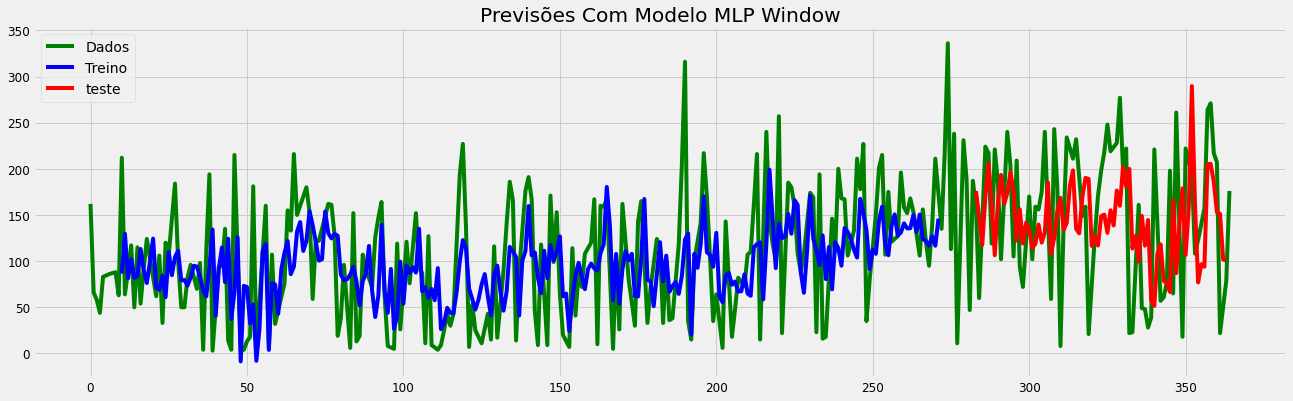

In [43]:
# Plot do baseline e previsões
# Podemos ver que o erro foi reduzido em comparação com o da seção anterior. 
# O tamanho da janela e a arquitetura da rede não foram sintonizados, isso é apenas uma demonstração de como
# enquadrar um problema de previsão em séries temporais. 
# Plot
plt.figure(figsize = (20, 6))
plt.title('Previsões Com Modelo MLP Window')
plt.plot(dataset, label = 'Dados', color = 'green')
plt.plot(trainPredictPlot, label = 'Treino', color = 'blue')
plt.plot(testPredictPlot, label = 'teste', color = 'Red')
plt.legend(loc = 'upper left')
plt.show()

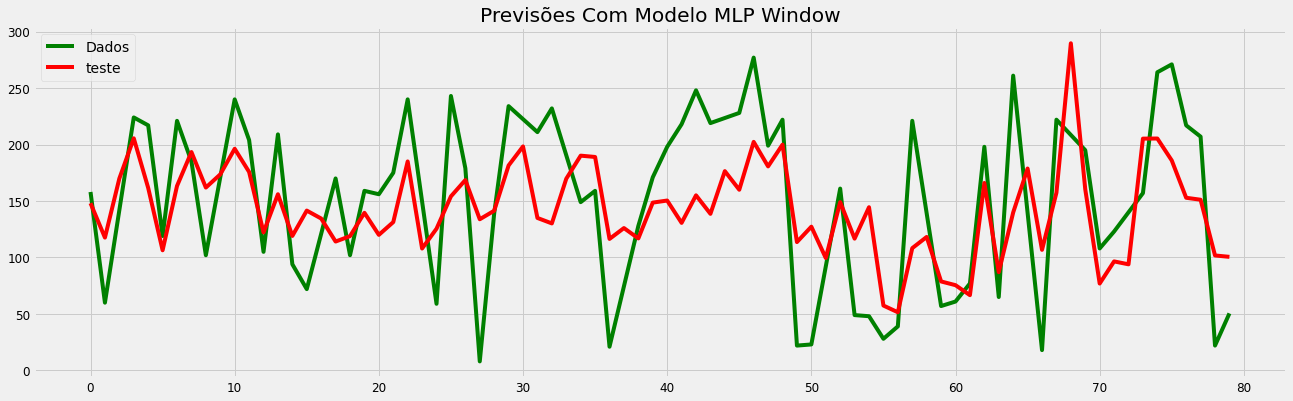

In [44]:
# Plot
plt.figure(figsize = (20, 6))
plt.title('Previsões Com Modelo MLP Window')
plt.plot(test[-len(testPredict)-1:-2], label = 'Dados', color = 'green')
plt.plot(testPredictPlot[-len(testPredict-1):], label = 'teste', color = 'Red')
plt.legend(loc = 'upper left')
plt.show()

## Vamos fazer o Forecasting para 82 dias de horizonte de previsão

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Fazemos uma previsão em uma etapa
def forecast_lstm(model, X):
    X = X.reshape(1, look_back)
    yhat = model.predict(X)
#    yhat1 = scaler.inverse_transform(yhat)
    return yhat[0,0]

In [47]:
# Validação direta nos dados de teste

# Lista para as previsões
previsoes_lstm = list()

# Previsões

for i in range(len(testX)):   
   
    # Ajusta o shape dos dados de teste
    X, y = testX[i], testY[i]
    
    # Previsão

    yhat = forecast_lstm(model, X)
    
    # Armazena o forecast
    previsoes_lstm.append(yhat)
    expected = raw_values[len(testX) + i ]
    
    print('Mês = %d, Valor Previsto = %f, Valor Esperado = %f' % (i + 1, yhat, expected))

Mês = 1, Valor Previsto = 176.018082, Valor Esperado = 96.000000
Mês = 2, Valor Previsto = 148.076782, Valor Esperado = 51.000000
Mês = 3, Valor Previsto = 117.605446, Valor Esperado = 6.000000
Mês = 4, Valor Previsto = 169.944672, Valor Esperado = 152.000000
Mês = 5, Valor Previsto = 205.523529, Valor Esperado = 13.000000
Mês = 6, Valor Previsto = 161.613907, Valor Esperado = 19.000000
Mês = 7, Valor Previsto = 106.375443, Valor Esperado = 107.000000
Mês = 8, Valor Previsto = 163.356430, Valor Esperado = 91.000000
Mês = 9, Valor Previsto = 193.360901, Valor Esperado = 81.500000
Mês = 10, Valor Previsto = 161.911926, Valor Esperado = 72.000000
Mês = 11, Valor Previsto = 173.585114, Valor Esperado = 126.000000
Mês = 12, Valor Previsto = 196.245926, Valor Esperado = 147.000000
Mês = 13, Valor Previsto = 175.735641, Valor Esperado = 164.000000
Mês = 14, Valor Previsto = 122.193611, Valor Esperado = 62.000000
Mês = 15, Valor Previsto = 155.998810, Valor Esperado = 8.000000
Mês = 16, Valor 

In [48]:
# Última data da série
target.index[-1]

Timestamp('2022-10-25 00:00:00', freq='D')

In [49]:
# Cria sequência de datas a partir da última data da nossa série original

datas_para_prever_forecasting = [target.index[-1] + DateOffset(days = x) for x in range(0, 82)]

In [51]:
# Objetos do tipo pd.Series dão mais trabalho para manipular. Vamos converter a série original em dataframe.
df_original = pd.DataFrame(target)

In [52]:
# Vamos agora criar um novo dataframe 
# O índice (data) será a sequência de datas futuras
# O nome da coluna de dados extraímos da série original
# ATENÇÃO: Não estamos extraindo os dados da série original, somente o nome da coluna
data_futuras = pd.DataFrame(index = datas_para_prever_forecasting[1:], columns = df_original.columns)

In [53]:
# Visualiza os dados
# Entendeu por que os valores NaN? São datas futuras, e precisamos agora incluir nossas previsões.
data_futuras

,Quantidade
2022-10-26,NaN
2022-10-27,NaN
2022-10-28,NaN
2022-10-29,NaN
2022-10-30,NaN
...,...
2023-01-10,NaN
2023-01-11,NaN
2023-01-12,NaN
2023-01-13,NaN


In [54]:
# Usamos as datas futuras para extrair as previsões do nosso modelo
df_predict = pd.DataFrame(testPredict,
                          index = data_futuras.index, columns = ['Prediction'])

In [55]:
# Concatenamos a série original com os valores de forecasting de 134 dias além da série
df_forecasting = pd.concat([df_original, df_predict], axis = 1)

In [56]:
# Visualiza o dataframe
df_forecasting

,Quantidade,Prediction
2021-10-26,162.0,NaN
2021-10-27,66.0,NaN
2021-10-28,58.0,NaN
2021-10-29,44.0,NaN
2021-10-30,83.0,NaN
...,...,...
2023-01-10,NaN,185.902771
2023-01-11,NaN,152.867996
2023-01-12,NaN,151.135696
2023-01-13,NaN,101.793152


In [57]:
df_forecasting.to_csv(r'./CSV/PipaMainframe_Forecasting_MLP_Window.csv', index = False)

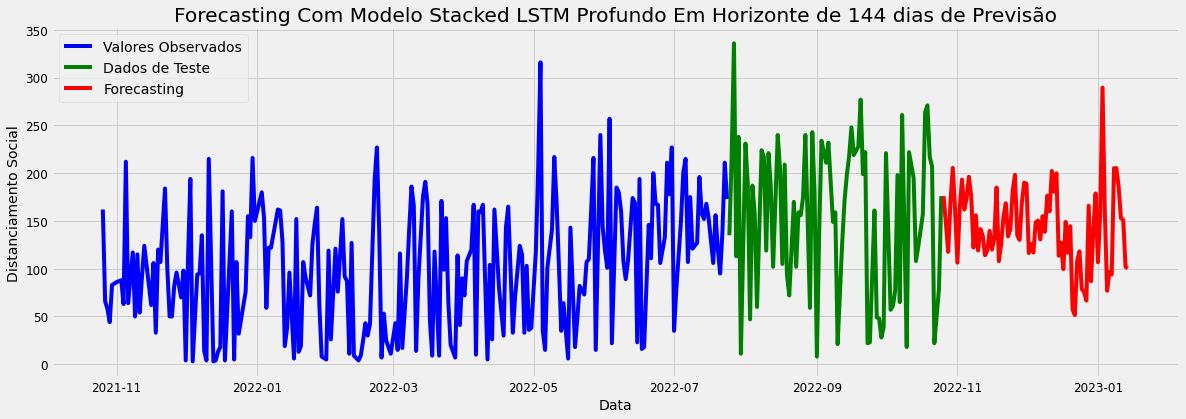

In [58]:
# Plot
plt.figure(figsize = (18, 6))

# Série original
plt.plot(target.index[0:272], target.values[0:272], label = 'Valores Observados', color = 'Blue')
plt.plot(target.index[272:], target.values[272:], label = 'Dados de Teste', color = 'green')

# Previsões
plt.plot(df_forecasting.index, df_forecasting['Prediction'], label = 'Forecasting',  color = 'Red')

plt.title('Forecasting Com Modelo Stacked LSTM Profundo Em Horizonte de 82 dias de Previsão')
plt.xlabel('Data')
plt.ylabel('Distanciamento Social')
plt.legend()
plt.show()

# Fim